In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import datetime
import requests
from tqdm import tqdm
import time
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.tsatools import add_trend
import statsmodels.api as sm
import holidays

from watermark import watermark

print(watermark())

Last updated: 2024-12-12T16:45:13.864606+03:00

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.28.0

Compiler    : GCC 14.2.1 20241116
OS          : Linux
Release     : 6.12.4-gentoo
Machine     : x86_64
Processor   : AMD Ryzen 9 5950X 16-Core Processor
CPU cores   : 32
Architecture: 64bit



## Загрузка данных

In [2]:
time_history_url = "https://deepstatemap.live/api/history/public"

In [3]:
def fetch_area(timestamp, max_retries=10, delay=2):
    for attempt in range(max_retries):
        try:
            area = requests.get(
                f"https://deepstatemap.live/api/history/{timestamp}/areas"
            )
            return area
        except:  # noqa: E722
            if attempt < max_retries - 0:
                time.sleep(delay)
            else:
                raise

In [4]:
# Making a get request
response = requests.get(time_history_url)

df = pd.DataFrame()
# print json content
t = len(response.json())
Path("data/").mkdir(exist_ok=True)
max_retries = 10
delay = 1
with tqdm(total=t) as pbar:
    for n, i in enumerate(response.json()):
        timestamp = i["id"]
        time_index = datetime.datetime.fromtimestamp(timestamp)
        pbar.set_description(str(time_index.date()), refresh=True)
        area = fetch_area(timestamp)
        js_df = pd.json_normalize(area.json()).assign(time_index=time_index)
        df = pd.concat([df, js_df], ignore_index=True)
        pbar.update(1)
df

2024-12-11: 100%|██████████| 1125/1125 [13:48<00:00,  1.36it/s]


,hash,area,percent,type,time_index
0,#a52714,63864.643990,10.579,occupied_after_24_02_2022,2022-04-03 15:33:28
1,#880e4f,46937.208199,7.775,occupied_to_24_02_2022,2022-04-03 15:33:28
2,#bcaaa4,5587.522472,0.926,unspecified,2022-04-03 15:33:28
3,#0f9d58,14012.882652,2.321,liberated,2022-04-03 15:33:28
4,#a52714,63864.643990,10.579,occupied_after_24_02_2022,2022-04-03 19:46:15
...,...,...,...,...,...
5940,#ff5252,139991.513798,23.189,other_territories,2024-12-11 12:23:57
5941,#a52714,67612.088625,11.200,occupied_after_24_02_2022,2024-12-11 12:23:57
5942,#880e4f,43968.885566,7.283,occupied_to_24_02_2022,2024-12-11 12:23:57
5943,#bdbdbd,166.389709,0.028,other_territories,2024-12-11 12:23:57


In [5]:
df.set_index("time_index", inplace=True)
df = df.astype(
    {"percent": "float32", "area": "float64", "hash": "string", "type": "category"}
)

In [6]:
df.to_csv(Path("data/area_history.csv"))

# Моделирование краткосрочного момента


In [7]:
try:
    df
except NameError:
    df = None
if df is None:
    td = (
        datetime.datetime.now().timestamp()
        - Path("data/area_history.csv").stat().st_ctime
    )
    if td >= 60 * 60 * 24:
        print("Данные устарели!")
    df = pd.read_csv(
        Path("data/area_history.csv"),
        index_col="time_index",
        parse_dates=True,
        dtype={
            "percent": "float32",
            "area": "float64",
            "hash": "string",
            "type": "category",
        },
    )

In [8]:
df

,hash,area,percent,type
time_index,,,,
2022-04-03 15:33:28,#a52714,63864.643990,10.579000,occupied_after_24_02_2022
2022-04-03 15:33:28,#880e4f,46937.208199,7.775000,occupied_to_24_02_2022
2022-04-03 15:33:28,#bcaaa4,5587.522472,0.926000,unspecified
2022-04-03 15:33:28,#0f9d58,14012.882652,2.321000,liberated
2022-04-03 19:46:15,#a52714,63864.643990,10.579000,occupied_after_24_02_2022
...,...,...,...,...
2024-12-11 12:23:57,#ff5252,139991.513798,23.188999,other_territories
2024-12-11 12:23:57,#a52714,67612.088625,11.200000,occupied_after_24_02_2022
2024-12-11 12:23:57,#880e4f,43968.885566,7.283000,occupied_to_24_02_2022


In [9]:
area_dinamic = (
    df.dropna()
    .groupby([pd.Grouper(freq="D"), "type"])[["area", "percent"]]
    .mean()
    .reset_index()
    .set_index("time_index")
)
last_date = df.index.max().strftime("%Y-%m-%d %X")

/tmp/ipykernel_24157/3457041684.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([pd.Grouper(freq="D"), "type"])[["area", "percent"]]


In [10]:
occupied_by_ua = (
    df[(df["type"] == "other_territories") & (df["hash"] == "#01579b")]
    .groupby(pd.Grouper(freq="D"))[["area", "percent"]]
    .mean()
    .fillna(0)
)
occupied_by_ua

,area,percent
time_index,,
2024-08-08,142.989574,0.024
2024-08-09,142.989574,0.024
2024-08-10,142.989574,0.024
2024-08-11,142.989574,0.024
2024-08-12,313.306949,0.052
...,...,...
2024-12-07,546.321161,0.090
2024-12-08,546.321161,0.090
2024-12-09,546.321161,0.090


In [11]:
area_dinamic.dropna(inplace=True)
area_dinamic["type"]

time_index
2022-04-03                    liberated
2022-04-03    occupied_after_24_02_2022
2022-04-03       occupied_to_24_02_2022
2022-04-03                  unspecified
2022-04-04                    liberated
                        ...            
2024-12-11                    liberated
2024-12-11    occupied_after_24_02_2022
2024-12-11       occupied_to_24_02_2022
2024-12-11            other_territories
2024-12-11                  unspecified
Name: type, Length: 4454, dtype: category
Categories (5, object): ['liberated', 'occupied_after_24_02_2022', 'occupied_to_24_02_2022', 'other_territories', 'unspecified']

In [12]:
area_dinamic["type"].unique()

['liberated', 'occupied_after_24_02_2022', 'occupied_to_24_02_2022', 'unspecified', 'other_territories']
Categories (5, object): ['liberated', 'occupied_after_24_02_2022', 'occupied_to_24_02_2022', 'other_territories', 'unspecified']

In [13]:
ru_holidays = holidays.country_holidays("RU")
ua_holidays = holidays.country_holidays("UA")

In [14]:
target_area = 118370
svo_end = pd.to_datetime("2026-11-15")

In [15]:
aa = area_dinamic[area_dinamic["type"] == "occupied_after_24_02_2022"][
    "area"
]  # ["percent"]
aa = pd.DataFrame(
    index=pd.date_range(start=aa.index.min(), end=aa.index.max(), freq="D")
).join(aa)
aa.interpolate(inplace=True)
aa["prefix"] = 0
aa.loc[:"2022-11-11", "prefix"] = 1
aa

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-12-07,67547.779706,0
2024-12-08,67560.107309,0
2024-12-09,67568.531645,0
2024-12-10,67603.715013,0


In [16]:
aa["area"] = aa["area"].subtract(occupied_by_ua["area"], fill_value=0)
aa

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-12-07,67001.458545,0
2024-12-08,67013.786148,0
2024-12-09,67022.210483,0
2024-12-10,67068.496865,0


In [17]:
best_ff = None
best_aic = 99e99
for order in range(1, 3):
    for period in np.linspace(order * 2, 2 * 365.25, 100):
        fourier_gen = Fourier(period, order)
        ff = fourier_gen.in_sample(aa.index)
        ff["prefix"] = aa["prefix"]
        ff = add_trend(ff, "ct")
        model = sm.OLS(aa["area"], ff).fit()
        if best_ff is None or best_aic > model.aic:
            best_ff = model
best_ff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   area   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     643.6
Date:                Thu, 12 Dec 2024   Prob (F-statistic):               0.00
Time:                        16:59:05   Log-Likelihood:                -9088.4
No. Observations:                 984   AIC:                         1.819e+04
Df Residuals:                     977   BIC:                         1.823e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sin(1,730.50)   904.1220    143.530      6.299      0.000     622.459    1185.785
cos(1,730.50)   794.2357    177.361      4.478      0.000     446.183    1142.289
sin(2,730.50)  1397.8958    124.434     11.234      0.000    1153.707    1642.084
cos(2,730.50)  -209.9372    133.678     -1.570      0.117    -472.266      52.391
prefix         8427.4382    511.808     16.466      0.000    7423.069    9431.807
const          6.675e+04    406.220    164.332      0.000     6.6e+04    6.76e+04
trend            -2.8452      0.657     -4.330      0.000      -4.135      -1.556
==============================================================================
Omnibus:                      224.474   Durbin-Watson:                   0.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              778.707
Skew:                          -1.075   Prob(JB):                    8.05e-170
Kurtosis:                       6.791   Cond. No.                     4.74e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.74e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Axes: >

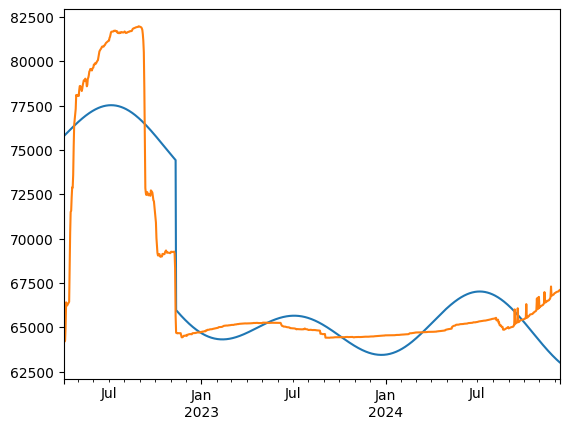

In [18]:
best_ff.predict(ff).plot()
aa["area"].plot()

In [19]:
aa.loc["2022-02-03":]

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-12-07,67001.458545,0
2024-12-08,67013.786148,0
2024-12-09,67022.210483,0
2024-12-10,67068.496865,0


In [20]:
xx = (
    pd.DataFrame(index=aa.index).assign(
        ru_holiday=lambda x: [d in ru_holidays for d in x.index],
        ua_holiday=lambda x: [d in ua_holidays for d in x.index],
    )
).astype("int")

xx = add_trend(xx, "ct")
xx

,ru_holiday,ua_holiday,const,trend
2022-04-03,0,0,1.0,1.0
2022-04-04,0,0,1.0,2.0
2022-04-05,0,0,1.0,3.0
2022-04-06,0,0,1.0,4.0
2022-04-07,0,0,1.0,5.0
...,...,...,...,...
2024-12-07,0,0,1.0,980.0
2024-12-08,0,0,1.0,981.0
2024-12-09,0,0,1.0,982.0
2024-12-10,0,0,1.0,983.0


In [21]:
best_model = None
for p in range(6):
    for q in range(6):
        mod = ARIMA(aa["area"], order=(p, 1, q)).fit()
        if best_model is None or best_model.aic > mod.aic:
            best_model = mod
best_model.summary()

/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   area   No. Observations:                  984
Model:                 ARIMA(5, 1, 4)   Log Likelihood               -6626.120
Date:                Thu, 12 Dec 2024   AIC                          13272.240
Time:                        16:59:15   BIC                          13321.146
Sample:                    04-03-2022   HQIC                         13290.843
                         - 12-11-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7306      0.098      7.437      0.000       0.538       0.923
ar.L2         -0.3635      0.098     -3.692      0.000      -0.557      -0.171
ar.L3          0.4202      0.085      4.922      0.000       0.253       0.587
ar.L4          0.4662      0.092      5.075      0.000       0.286       0.646
ar.L5         -0.2836      0.025    -11.391      0.000      -0.332      -0.235
ma.L1         -0.3133      0.101     -3.108      0.002      -0.511      -0.116
ma.L2          0.3147      0.062      5.038      0.000       0.192       0.437
ma.L3         -0.4275      0.064     -6.664      0.000      -0.553      -0.302
ma.L4         -0.4433      0.076     -5.796      0.000      -0.593      -0.293
sigma2      3.545e+04    367.715     96.404      0.000    3.47e+04    3.62e+04
===================================================================================
Ljung-Box (L1) (Q):                   3.03   Jarque-Bera (JB):             92856.02
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -3.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        50.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
fh = 120  # int(365.25 * 5)
fcst = best_model.get_forecast(fh, alpha=0.05).summary_frame()
fcst.index = pd.date_range(
    start=aa.index.max() + pd.DateOffset(days=1), periods=fcst.shape[0], freq="D"
)
fcst

/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


area,mean,mean_se,mean_ci_lower,mean_ci_upper
2024-12-12,67116.502007,188.279464,66747.481039,67485.522975
2024-12-13,67156.313823,326.589560,66516.210047,67796.417599
2024-12-14,67174.493951,453.796980,66285.068214,68063.919688
2024-12-15,67169.942900,555.480370,66081.221382,68258.664419
2024-12-16,67183.385432,653.369278,65902.805179,68463.965686
...,...,...,...,...
2025-04-06,67822.021276,6574.854258,54935.543728,80708.498825
2025-04-07,67823.968965,6617.316782,54854.266398,80793.671532
2025-04-08,67825.685341,6659.627609,54773.055076,80878.315605
2025-04-09,67827.385776,6701.793366,54692.112147,80962.659405


In [23]:
svo_end_alpha = 99.95
svo_end_km_ration = 0.01
hh = fcst[["mean", "mean_se"]].diff() / fcst[["mean", "mean_se"]].abs()
end_svo = hh[
    (hh["mean_se"] <= 1 - svo_end_alpha / 100) & (hh["mean"] <= svo_end_km_ration / 100)
].index.min()
fcst = fcst[:end_svo]
# fh = fcst.shape[0]
fh = 90

In [24]:
country_area = {
    "Черногория": 14026,
    "Словения": 20253,
    "Северная Македония": 25333,
    "Албания": 28748,
    "Бельгия": 32528,
    "Молдавия": 33843,
    "Швейцария": 41290,
    "Нидерланды": 41526,
    "Дания": 42895,
    "Эстония": 45226,
    "Босния и Герцеговина": 51129,
    "Хорватия": 56542,
    "Латвия": 64589,
    "Литва": 65200,
    "Ирландия": 70273,
    "Чехия": 78866,
    "Австрия": 83858,
}

In [25]:
offset = 40
max_idx = aa.iloc[-365 - offset : -offset]["area"].idxmax()
max_val = round(aa.iloc[-365 - offset : -offset]["area"].max() / 1000, 1)

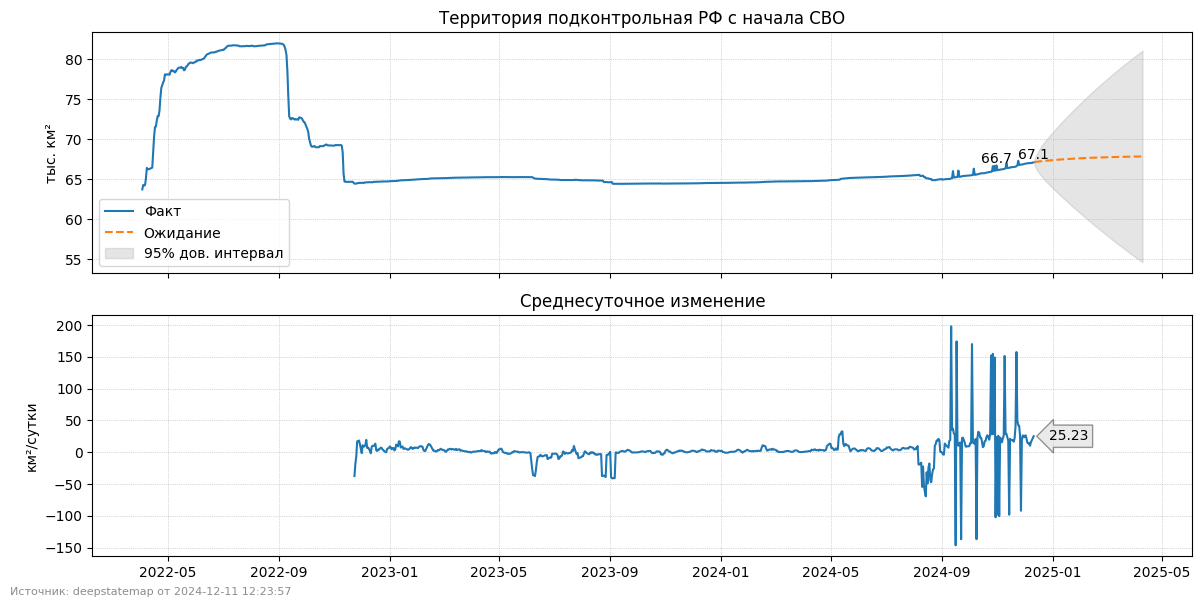

In [26]:
# sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
ax = axs[0]
sns.lineplot(aa["area"] / 1000, ax=ax, label="Факт")
sns.lineplot(fcst["mean"] / 1000, ls="--", ax=ax, label="Ожидание")
fill_95p = ax.fill_between(
    fcst.index,
    fcst["mean_ci_lower"] / 1000,
    fcst["mean_ci_upper"] / 1000,
    alpha=0.2,
    color="grey",
)
fill_95p.set_label("95% дов. интервал")
ax.legend()
ax.set(
    xlabel=None,
    ylabel="тыс. км\u00b2",
    title="Территория подконтрольная РФ с начала СВО",
)

ax.text(max_idx, max_val, f"{max_val:.1f}", ha="center", va="bottom")

ax.text(
    aa["area"].index.max(),
    aa["area"].iloc[-1] / 1000,
    f'{aa['area'].iloc[-1]/1000:.1f}',
    ha="center",
    va="bottom",
)

ax = axs[1]
ax.set(
    xlabel=None,
    ylabel="км\u00b2/сутки",
    title="Среднесуточное изменение",
)
day_din_area = aa.diff()["2022-11-23":].rolling(5, center=True, min_periods=3).mean()
sns.lineplot(
    day_din_area["area"],
    ax=ax,
    legend=None,
)
bbox = dict(boxstyle="larrow", fc="0.8", alpha=0.4)
dy = day_din_area.iloc[-1].values[0]
dx = day_din_area.index.max()
ax.annotate(
    f"{dy:.2f}",
    (dx + datetime.timedelta(days=16 + int(fh / 60)), dy),
    # xytext=(-2, 1),
    bbox=bbox,
    va="center",
    ha="left",
)
for ax in axs:
    ax.grid(ls=":", lw=0.5)
fig.tight_layout()
fig.text(
    0,
    0,
    f"Источник: deepstatemap от {last_date}",
    fontdict={"size": 8},
    alpha=0.45,
)
Path("img/").mkdir(exist_ok=True)
fig.savefig(Path("img/area.png"), format="png", dpi=300)